In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
print(f' Shape of Train data with target column {train_data.shape}')
train_data.drop(['id'], axis =1, inplace=True)
IDs = test_data['id'].copy()
test_data.drop(['id'], axis =1, inplace=True)

 Shape of Train data with target column (89392, 12)


In [4]:
train_data.columns

Index(['gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy',
       'cltv'],
      dtype='object')

In [5]:
# To avoid the overlapping of x values later for income plots changing value 'more than 10L' to '>=10L'
train_data.income.replace(to_replace='More than 10L', value='>=10L', inplace= True)
test_data.income.replace(to_replace='More than 10L', value='>=10L', inplace= True)
train_data.income.unique()

array(['5L-10L', '>=10L', '2L-5L', '<=2L'], dtype=object)

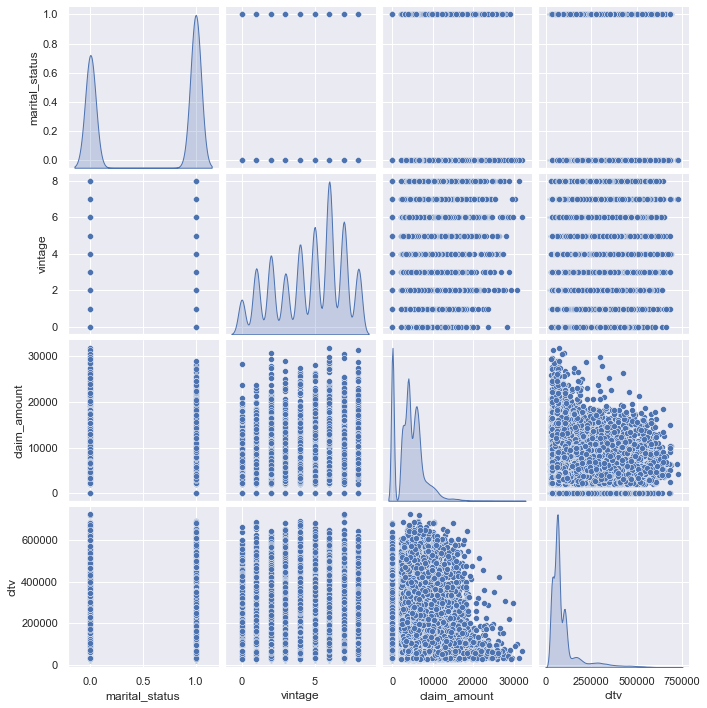

In [6]:
sns.pairplot(data=train_data, diag_kind='kde')

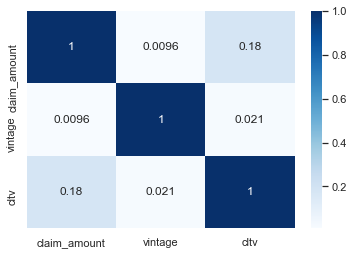

In [7]:
sns.heatmap(train_data[['claim_amount','vintage', 'cltv']].corr(), cmap='Blues', annot=True)
plt.show()

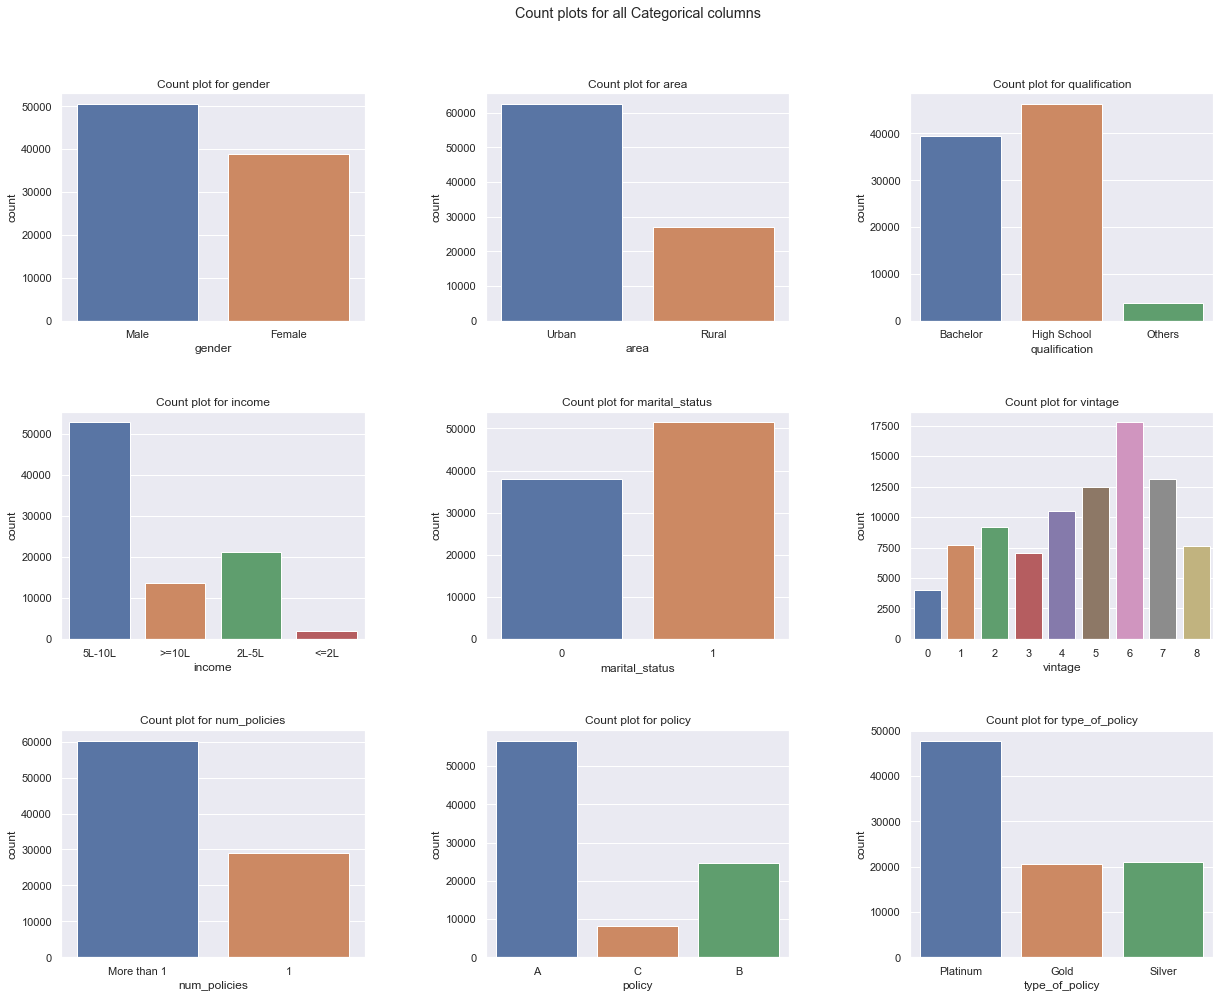

In [8]:
cat_columns = ['gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'num_policies', 'policy', 'type_of_policy']
fig, ax = plt.subplots(3, 3, figsize = (20, 15))
fig.suptitle('Count plots for all Categorical columns')
fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

x_index = 0
y_index = 0
for c in cat_columns:
    ax[(x_index), (y_index)].set_title(f'Count plot for {c}')
    sns.countplot(ax=ax[(x_index), (y_index)], x=c, data=train_data)
    y_index+=1
    if(y_index == 3):
        x_index += 1
        y_index = 0
    
plt.show()   

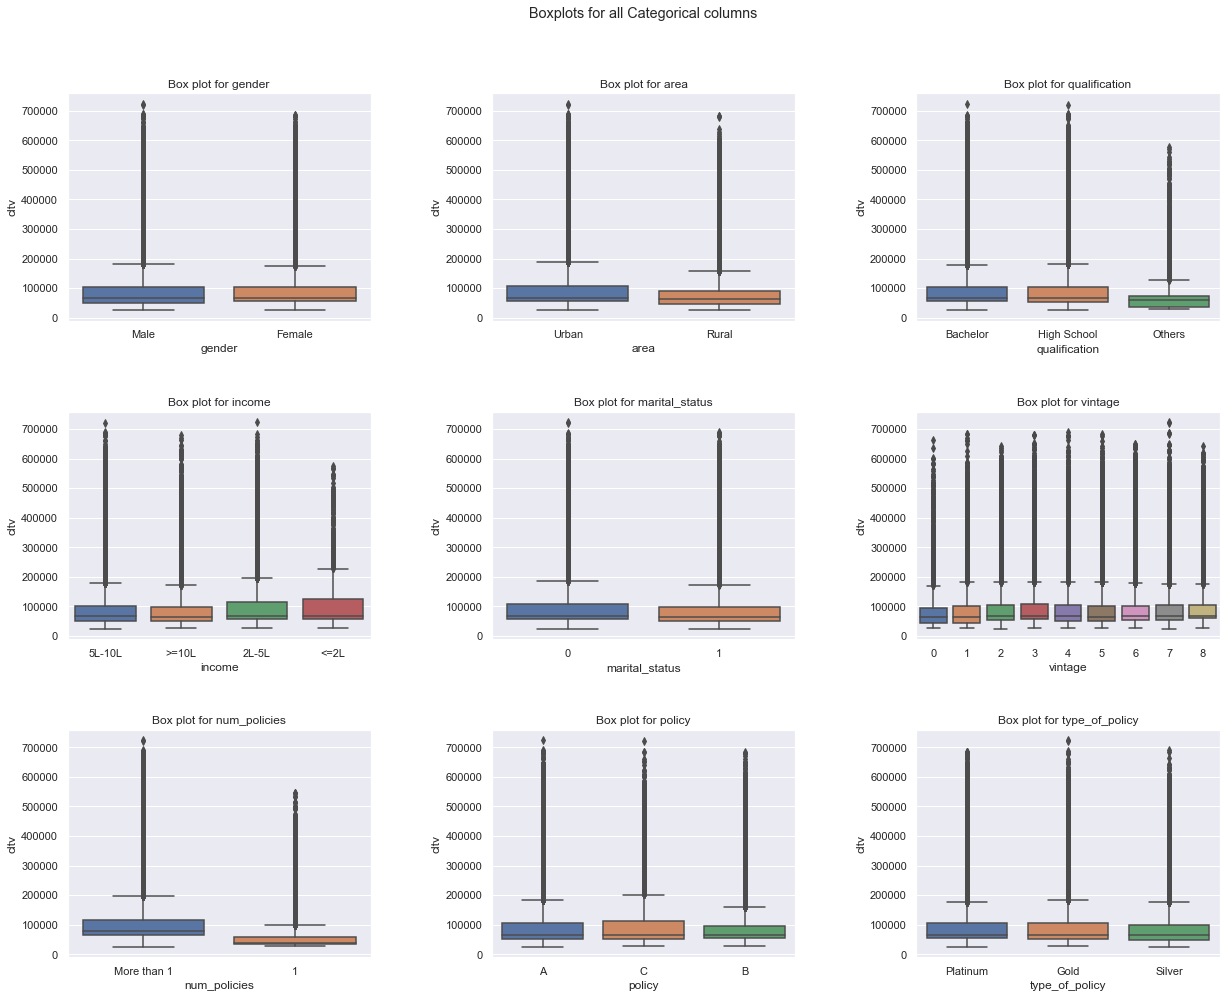

In [9]:
fig, ax = plt.subplots(3, 3, figsize = (20, 15))
fig.suptitle('Boxplots for all Categorical columns')
fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

x_index = 0
y_index = 0
for c in cat_columns:
    ax[(x_index), (y_index)].set_title(f'Box plot for {c}')
    sns.boxplot(ax=ax[(x_index), (y_index)], x=c, y='cltv', data=train_data)
    y_index+=1
    if(y_index == 3):
        x_index += 1
        y_index = 0
    
plt.show()  

In [10]:
# Based on the observation in cell 19 in Draft-1 and the above count and box plots
# 1. Qualification can be modified into 2 classes only, bachelor and other non-bachelor
# 2. Policy can also be modified into 2 classes only, A and (B&C)
# 3. Type Of Policy also be modified into 3 classes only, P, and (GS)
train_data['qualification'] = train_data['qualification'].apply(lambda x: 'Bachelor' if x == 'Bachelor' else 'Non_Bachelor')
train_data['policy'] = train_data['policy'].apply(lambda x: 'A' if x == 'A' else 'BnC')
train_data['type_of_policy'] = train_data['type_of_policy'].apply(lambda x: 'P' if x == 'Platinum' else 'GS')
test_data['qualification'] = test_data['qualification'].apply(lambda x: 'Bachelor' if x == 'Bachelor' else 'Non_Bachelor')
test_data['policy'] = test_data['policy'].apply(lambda x: 'A' if x == 'A' else 'BnC')
test_data['type_of_policy'] = test_data['type_of_policy'].apply(lambda x: 'P' if x == 'Platinum' else 'GS')

In [11]:
sc=StandardScaler()
train_data[['vintage', 'claim_amount']] = sc.fit_transform(train_data[['vintage', 'claim_amount']])
test_data[['vintage', 'claim_amount']] = sc.fit_transform(test_data[['vintage', 'claim_amount']])
#train_data[['vintage']] = sc.fit_transform(train_data[['vintage']])
#test_data[['vintage']] = sc.fit_transform(test_data[['vintage']])

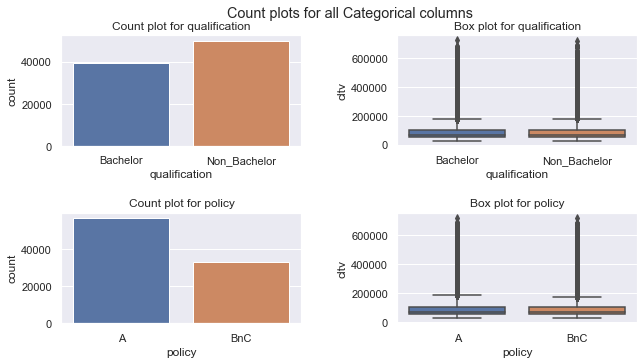

In [12]:
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
fig.suptitle('Count plots for all Categorical columns')
fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)

x_index = 0
y_index = 0
tmp_list = ['qualification', 'policy']
for c in tmp_list:
    
    ax[(x_index), (y_index)].set_title(f'Count plot for {c}')
    sns.countplot(ax=ax[(x_index), (y_index)], x=c, data=train_data)
    y_index+=1    
    ax[(x_index), (y_index)].set_title(f'Box plot for {c}')
    sns.boxplot(ax=ax[(x_index), (y_index)], x=c, y='cltv', data=train_data)
    
    y_index+=1
    if(y_index == 2):
        x_index += 1
        y_index = 0
    
plt.show()   

In [13]:
for c in cat_columns:
    lst = list(train_data[c].unique())
    if c == 'vintage':
        continue
    if len(lst) == 2:
        train_data[c].replace(lst, [0,1], inplace=True)
        train_data[c]=train_data[c].astype('int')
        test_data[c].replace(lst, [0,1], inplace=True)
        test_data[c]=test_data[c].astype('int')
        #continue
    else:
        new_data = pd.get_dummies(train_data, columns=[c])
        train_data.drop([c], axis =1, inplace=True)
        train_data = new_data.copy()
        new_data = pd.get_dummies(test_data, columns=[c])
        test_data.drop([c], axis =1, inplace=True)
        test_data = new_data.copy()
    

In [14]:
len(train_data.columns)

14

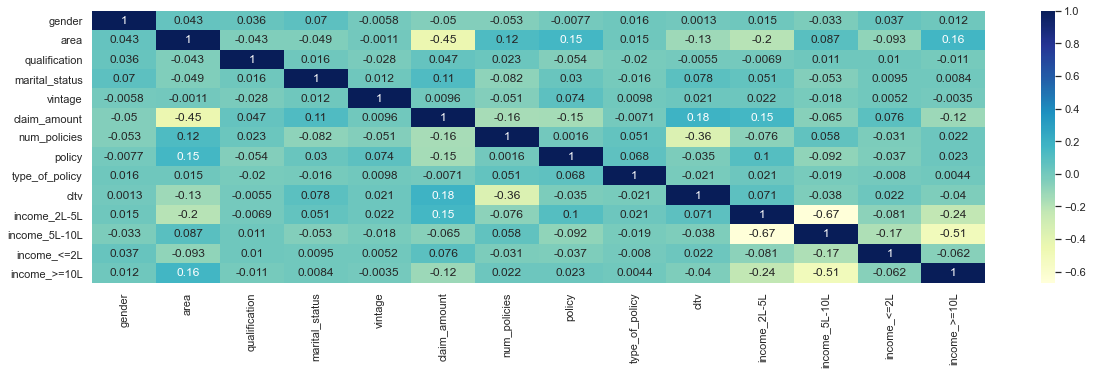

In [15]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
sns.heatmap(train_data.corr(), cmap='YlGnBu', annot=True)
plt.show()

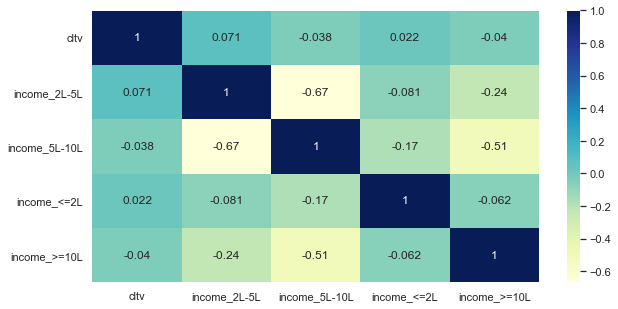

In [16]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
sns.heatmap(train_data[['cltv', 'income_2L-5L',
       'income_5L-10L', 'income_<=2L', 'income_>=10L']].corr(), cmap='YlGnBu', annot=True)
plt.show()

In [17]:
train_data.shape

(89392, 14)

In [18]:
X = train_data[['gender', 'area', 'qualification', 'marital_status', 'vintage',
       'claim_amount', 'num_policies', 'policy', 'income_2L-5L',
       'income_5L-10L', 'income_<=2L', 'income_>=10L', 'type_of_policy']].copy()
Y = train_data['cltv'].copy()
print(X.shape)

selectK = SelectKBest(f_regression, k=13)

X_new = selectK.fit_transform(X, Y)


(89392, 13)


In [19]:
X_train, X_test,y_train, y_test = train_test_split(X_new,Y.values ,\
                                   random_state=40, 
                                   test_size=0.25, 
                                   shuffle=True)

In [20]:
#Linear Regression
regressor = LinearRegression(fit_intercept=True)
regressor.fit(X_train,y_train)
ypred = regressor.predict(X_test)
print(f'''Linear Regression evaluation metrics:: r2-Score: {r2_score(y_test, ypred)}, MAE: {mean_absolute_error(y_test, ypred)} 
 and RMSE: {np.sqrt(mean_squared_error(y_test, ypred))}''')

Linear Regression evaluation metrics:: r2-Score: 0.14129128786000467, MAE: 51727.43762305352 
 and RMSE: 84703.22703430736


In [21]:
poly_regressor = PolynomialFeatures(degree=2)
X_train1 = poly_regressor.fit_transform(X_train)
X_test1 = poly_regressor.fit_transform(X_test)
print(X_train1.shape, X_test1.shape)

(67044, 105) (22348, 105)


In [22]:
#Polynomial Regression
regressor = LinearRegression(fit_intercept=True)
regressor.fit(X_train1,y_train)
ypred = regressor.predict(X_test1)
print(f'''Linear Regression evaluation metrics:: 
 r2-Score: {r2_score(y_test, ypred)}, 
 MAE: {mean_absolute_error(y_test, ypred)} 
 and RMSE: {np.sqrt(mean_squared_error(y_test, ypred))}''')

Linear Regression evaluation metrics:: 
 r2-Score: 0.1467943773123005, 
 MAE: 51185.92885269375 
 and RMSE: 84431.37778187182


In [23]:
# Lasso Regression
regressor_L = Lasso(alpha = 30)
regressor_L.fit(X_train1,y_train)
ypred = regressor_L.predict(X_test1)
print(f'''Linear Regression evaluation metrics:: 
 r2-Score: {r2_score(y_test, ypred)}, 
 MAE: {mean_absolute_error(y_test, ypred)} 
 and RMSE: {np.sqrt(mean_squared_error(y_test, ypred))}''')

Linear Regression evaluation metrics:: 
 r2-Score: 0.1471273012750295, 
 MAE: 51040.27816171077 
 and RMSE: 84414.90345801691


In [24]:
# Ridge Regression
regressor_R = Ridge(alpha = 200)
regressor_R.fit(X_train1,y_train)
ypred = regressor_R.predict(X_test1)
print(f'''Linear Regression evaluation metrics:: 
 r2-Score: {r2_score(y_test, ypred)}, 
 MAE: {mean_absolute_error(y_test, ypred)} 
 and RMSE: {np.sqrt(mean_squared_error(y_test, ypred))}''')

Linear Regression evaluation metrics:: 
 r2-Score: 0.1471369865046782, 
 MAE: 51037.33474495746 
 and RMSE: 84414.42414847393


In [25]:
X_test = test_data[['gender', 'area', 'qualification', 'marital_status', 'vintage',
       'claim_amount', 'num_policies', 'policy', 'income_2L-5L',
       'income_5L-10L', 'income_<=2L', 'income_>=10L', 'type_of_policy']].copy()
print(X_test.shape)
X_test = poly_regressor.fit_transform(X_test)


(59595, 13)


In [26]:
solution_data = pd.DataFrame()
solution_data['id'] = IDs
solution_data['cltv'] = regressor_R.predict(X_test)
solution_data=solution_data.set_index('id')

In [27]:
solution_data.to_csv('sample_submission.csv')